# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Цель проекта: построить модель для определения стоимости автомобиля
Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

Признаки
DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Подготовка данных

загрузим все необходимые библиотеки

In [1]:
import time

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from tqdm import trange

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

In [3]:
#Загрузим данные 
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
#выведем на экран датафрейм
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# поменяем формат даты
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M')

In [6]:
#посмотрим на размер представленных данных
print(f'Размер набора данных: {df.shape}')

Размер набора данных: (354369, 16)


In [7]:
# проверим названия колонок
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [8]:
#изучим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [9]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 4


In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
df.describe(include=['object', 'bool'])

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


### Выводы
- Размер набора данных: (354369, 16)
- Количество дубликатов: 4
- Минимальный срок регистрации автомобиля 1000 год, максимальный 9999г. Что-то явно не так
- Максимальная мощность авто 20000 л.с., что-то явно не так
- Максимальный пробег 150000. Выглядит не совсем реалистично, скорее всего значения больше просто нельзя поставить
- Минимальный месяц регистрации 0, максимальный 12. Тоже что-то не так, ведь в году не может быть 13 месяцев
- Самый популярный тип автомобиля седан
- Самая популярная коробка - механика
- Самый популярный бренд volkswagen, модель - golf
- Чаще всего встречаются автомобили на бензине
- В столбце ремонт множество значений, однако большинство авто встречаются без ремонта. Скорее всего авто либо не ремонтировалось, либо владелец решил скрыть эту информацию
- Названия колонок не соответствуют правилам хорошего стиля

In [12]:
#Приведем название колонок с нижнему регистру согласно правилам хорошего стиля
df.columns = map(str.lower, df.columns)
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [13]:
# В нашем датафрейме 4 явных дубликата, удалим их 
df = df.drop_duplicates()
# сразу проверим
print(f'Количество явных дубликатов: {df.duplicated().sum()}')

Количество явных дубликатов: 0


По условиям задачи, если у нас есть неинформативные признаки, то есть те, которые не влияют на стоимость автомобиля, то нужно их удалить

Список неинформативных признаков
- datecreated - дата создания анкеты
- registrationmonth - месяц регистрации
- numberofpictures - количество фотографий авто
- postalcode - индекс почты владельца анкеты
- lastseen - последняя активность пользователя

In [14]:
# удалим неинформативные признаки
df = df.drop(['datecreated', 'registrationmonth', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [15]:
data = df.drop_duplicates().reset_index(drop=True)

## Обработка пропусков 

In [16]:
# Найдем количество пропусков в столбцах, в которых они есть
df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")

,empty_value
vehicletype,37490
gearbox,19833
model,19705
fueltype,32895
repaired,71154


### Столбец vehicletype

In [17]:
vehicles = df['vehicletype'].value_counts()
vehicles_data = pd.DataFrame({'Типы автомобилей': vehicles}).sort_values(by='Типы автомобилей', ascending=False)
vehicles_data

,Типы автомобилей
sedan,91457
small,79830
wagon,65165
bus,28775
convertible,20203
coupe,16161
suv,11996
other,3288


Помимо пропусков, тут есть строчка other, пропуски можно к нему отнести

In [18]:
df['vehicletype'] = df['vehicletype'].fillna('other')

### Столбец gearbox

Присвоим пропускам значение unknown

In [19]:
df['gearbox'] = df['gearbox'].fillna('unknown')

### Столбец model

Отнесем пропуски к other

In [20]:
df['model'] = df['model'].fillna('other')

### Столбец fueltype

In [21]:
fuels = df['fueltype'].value_counts()
fuel_df = pd.DataFrame({'тип топлива': fuels}).sort_values(by='тип топлива', ascending=False)
fuel_df

,тип топлива
petrol,216349
gasoline,98719
lpg,5310
cng,565
hybrid,233
other,204
electric,90


Тут тоже есть other, отнесем его к группе other

In [22]:
df['fueltype'] = df['fueltype'].fillna('other')

В датафрейме есть скрытые дубликаты, ведь petrol и gasoline это одно и тоже

In [23]:
df['fueltype'] = df['fueltype'].str.replace('petrol','gasoline')

### Столбец repaired

Пропусков в данном столбце много, удалять их не буду. Присвоим пропускам значение unknown

In [24]:
df['repaired'] = df['repaired'].fillna('unknown')

## Обработка выбросов 

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datecrawled       354365 non-null  datetime64[ns]
 1   price             354365 non-null  int64         
 2   vehicletype       354365 non-null  object        
 3   registrationyear  354365 non-null  int64         
 4   gearbox           354365 non-null  object        
 5   power             354365 non-null  int64         
 6   model             354365 non-null  object        
 7   kilometer         354365 non-null  int64         
 8   fueltype          354365 non-null  object        
 9   brand             354365 non-null  object        
 10  repaired          354365 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 32.4+ MB


Поработаем отдельно для с каждым столбцом

### Столбец price

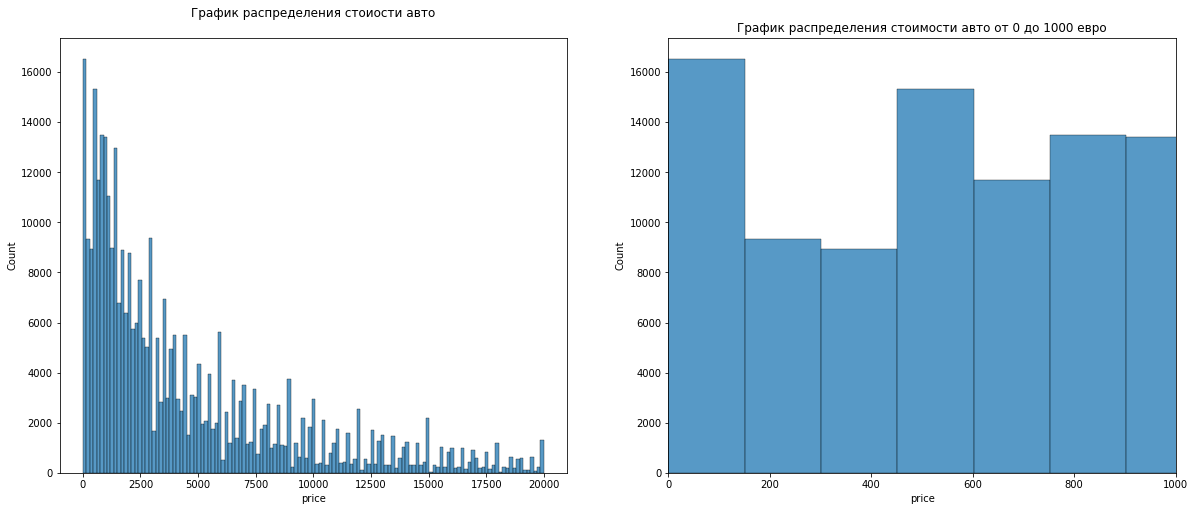

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(df['price'], ax=axes[0])
axes[0].set_title('График распределения стоиости авто\n')
sns.histplot(df['price'], ax=axes[1])
axes[1].set_title('График распределения стоимости авто от 0 до 1000 евро')
plt.xlim([0, 1000])
plt.show()

Автомобиль не может стоить 0 евро, в записях явно выбросы. Найдем количество авто с нулевой стоимостью 

In [27]:
zero_price = df.query('price == 0')['power'].count()
zero_price

10772

Автомобилей, у которых стоимость равна 0 аж 10к. В принципе, вряд-ли автомобиль может стоить меньше 100 евро, поэтому удалим эти данные

In [28]:
#найдем количество автомобилей, у которых выставлена стоимость менее 100 евро
price_100 = df.query('price < 100')['power'].count()
price_100

13314

In [29]:
# удалим эти данные из нашего датафрейма
df = df.query('price > 100')

### Столбец registrationyear

Поскольку явно есть выбросы (1000 год и 9999 явно выбросы), то зададим условия

Год выгрузки базы 2016, поэтому вернхнюю границу зададим такой

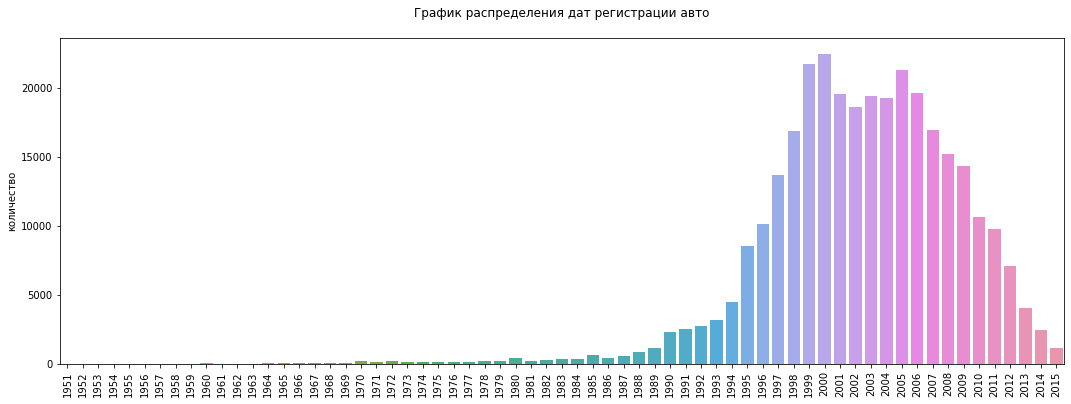

In [30]:
df_reg = df.query('registrationyear > 1950 & registrationyear < 2016')
plt.figure(figsize=(18, 6))
pivot_years = df_reg.pivot_table(index='registrationyear', values='power', aggfunc='count')
fig = sns.barplot(x=pivot_years.index, y='power', data=pivot_years)
plt.title('График распределения дат регистрации авто\n')
plt.xlabel('')
plt.ylabel('количество')
plt.setp(fig.get_xticklabels(),rotation=90)
plt.show()

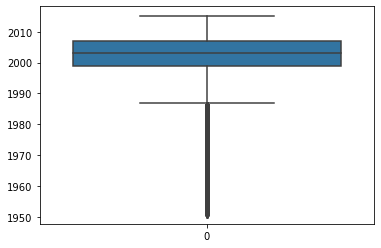

In [31]:
sns.boxplot(data=df_reg['registrationyear'])
plt.show()

Автомобилей, в которых датарегистрации до 1990 года немнного, однако исключать их не стоит.
Для дальнейшего исследования возьмем диапазон данных от 1950 по 2024г. 

In [32]:
df = df_reg

### Столбец power

Согласно описательной статистике мощность представленных авто от 0 л.с. до 2000 л.с. 0 - явно ошибка, от них надо избавиться. Слишком большая мощность это гиперкары, автомобили не были серийными, необходимо задать условия

Зададим условия, что мощность автомобилей варьируется в диапазоне от 50 ло 1500 л.с.

In [33]:
df_pow = df.query('power > 50 & power <= 1600')
data_pow = len(df) - len(df_pow)
data_pow

37965

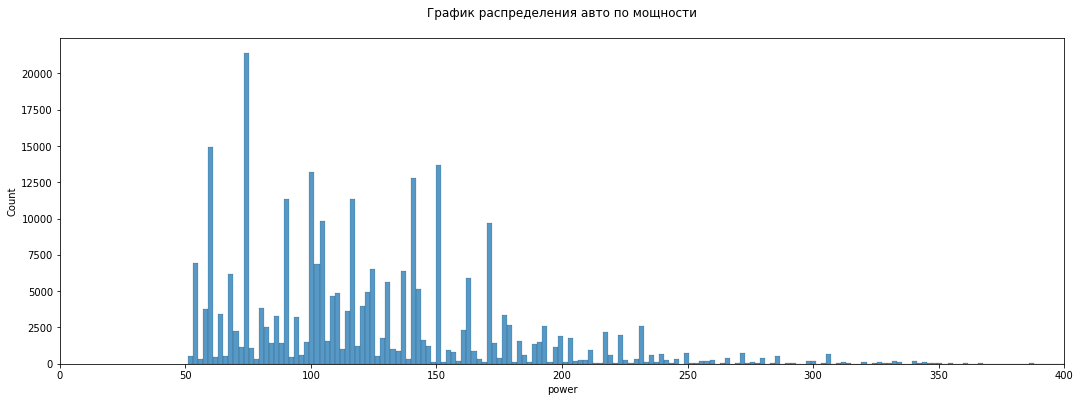

In [34]:
plt.figure(figsize=(18, 6))
sns.histplot(df_pow['power'])
plt.title('График распределения авто по мощности\n')
plt.xlim([0, 400])
plt.show()

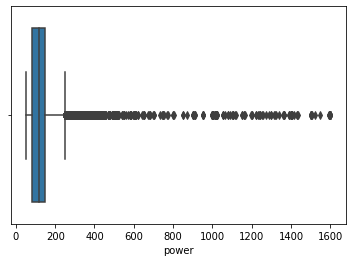

In [35]:
sns.boxplot(x=df_pow['power'])
plt.show()

Можно конечно задать более жесткие условия и существенно сузить наш диапазон, но это будет влиять на качество будущих моделей,поэтому оставим наши условия 

In [36]:
df = df_pow.copy()

### Столбец kilometer

Согласно описательной статистике, максимальный пробег 150 тыс. км., что кстати странно, это довольно немного. Минимальный 5 тыс.

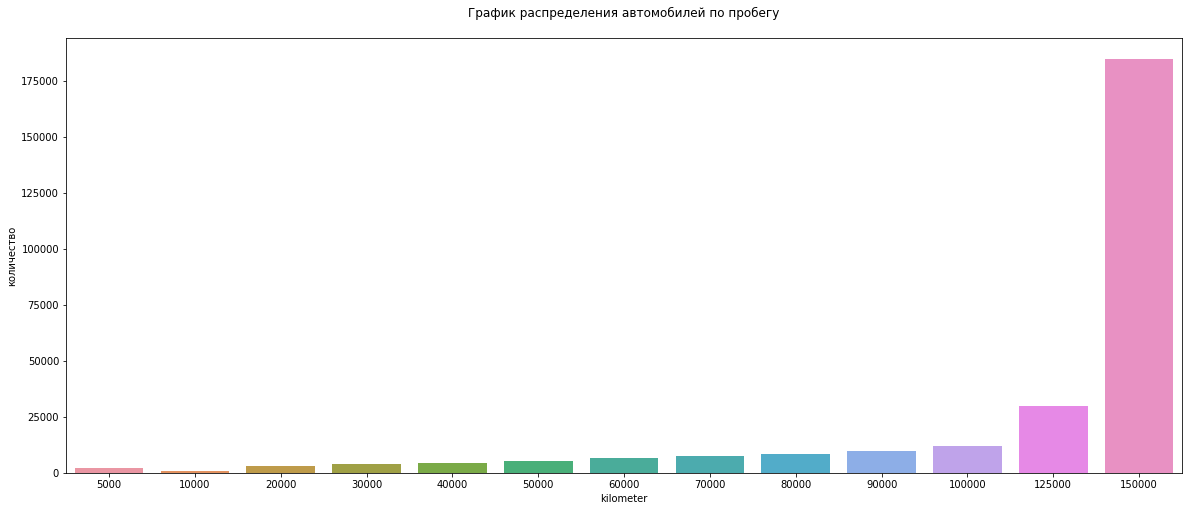

In [37]:
plt.figure(figsize=(20, 8))
pivot_kilometer = df.pivot_table(index='kilometer', values='price', aggfunc='count')
fig = sns.barplot(x=pivot_kilometer.index, y='price', data=pivot_kilometer)
plt.ylabel('количество')
plt.title('График распределения автомобилей по пробегу\n')
plt.show()

Здесь ничего изменять не будем. Такое большое количество автомобилей с пробегом 150 тыс. км скорее всего обусловлено тем, что в таблице есть значение 150+

## Подготовка выборок

In [38]:
# проверим ещй раз количество пропусков 
df.isnull().sum()

datecrawled         0
price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [39]:
#проверим еще раз количество дубликатов
df.duplicated().sum()

21

In [40]:
# удаление всех дубликатов из таблицы df 
df = df.drop_duplicates().reset_index(drop=True)

In [41]:
df = df.drop(['datecrawled'], axis=1)

In [42]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
279436,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
279437,3200,sedan,2004,manual,225,leon,150000,gasoline,seat,yes
279438,1199,convertible,2000,auto,101,fortwo,125000,gasoline,smart,no
279439,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [43]:
data_reg = df

Проверка данных на мультиколлинеарность

                     price  registrationyear     power  kilometer
price             1.000000          0.559021  0.447019  -0.395828
registrationyear  0.559021          1.000000  0.102442  -0.364848
power             0.447019          0.102442  1.000000   0.094967
kilometer        -0.395828         -0.364848  0.094967   1.000000


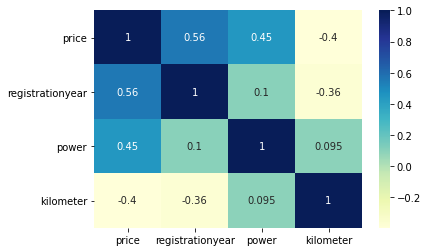

In [44]:
print(df.corr())
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Сильной зависимости между признаками не наблюдается

## Подготовка выборок

In [45]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
279436,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
279437,3200,sedan,2004,manual,225,leon,150000,gasoline,seat,yes
279438,1199,convertible,2000,auto,101,fortwo,125000,gasoline,smart,no
279439,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [46]:
df['model'].unique()

array(['other', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'civic', 'punto', 'e_klasse', 'kadett', 'one', 'fortwo',
       'clio', '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'micra',
       'vito', 'sprinter', '156', 'escort', 'forester', 'xc_reihe',
       'fiesta', 'scenic', 'ka', 'a1', 'transporter', 'focus', 'a4', 'tt',
       'astra', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er', 'combo',
       'corsa', '80', '147', 'z_reihe', 'sorento', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'insignia', 'megane', 'a3', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'lupo',
       'berlingo', 'tiguan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'fox', 'matiz', 'beetle', 'rio', 'touareg',
       'logan', 'spider', 'cuore', 's_max', 'modus', 'a2', 'galaxy', 'c3',
    

In [47]:
RANDOM_STATE = 42
# Разделение данных на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']
# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [48]:
#создадим списки количественных и категириальных признаков
numeric = ['registrationyear', 'power', 'kilometer']
categor = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [49]:
#поработаем с количественными признаками
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train[numeric])
X_test_scal = scaler.transform(X_test[numeric])

In [50]:
pip install -U scikit-learn

  Using cached scikit_learn-1.5.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Note: you may need to restart the kernel to use updated packages.


In [51]:
!pip install scikit-learn==1.1.3 -q

In [52]:
# теперь поработаем с категириальными принзнаками
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_train_ohe = encoder.fit(X_train[categor])

In [53]:
X_test_ohe = encoder.transform(X_test[categor])
encoder = encoder.get_feature_names_out()

### Выводы:
- привели названия столбцов к нижнему регистру согласно правилам хорошего стиля
- удалили неинформативные признаки:
- datecreated - дата создания анкеты
- registrationmonth - месяц регистрации
- numberofpictures - количество фотографий авто
- postalcode - индекс почты владельца анкеты
- lastseen - последняя активность пользователя
- обработали пропуски по каждому признаку отдельно
- также по каждому признаку отдельно обработали выбросы
- подготовили выборки

## Валидация

Для обучения моделей будем использовать кросс-валидацию 

In [55]:
CV = 3
SCORER = 'neg_root_mean_squared_error'

зададим функцию, рассчитывающую метрики качества моделей в результате кросс-валидации.

In [56]:
def cv_score(model, X=X_train, y=y_train):
    return abs(cross_val_score(model, X=X, y=y,
                               cv=CV, n_jobs=-1, error_score='raise',
                               scoring=SCORER).mean())

## Обучение моделей 

### Модель Linear Regression

In [57]:
#from sklearn.compose import ColumnTransformer

In [58]:
%%time
pipeliner = Pipeline([
    ('transformer', ColumnTransformer([
        ('encoder', OneHotEncoder(handle_unknown='ignore'),
         categor),
        ('scaler', StandardScaler(), numeric)
    ])),
    ('model', LinearRegression(n_jobs=-1))])

model_lr_score = cv_score(pipeliner)

print('Модель Linear Regression')
print('\nRMSE =', model_lr_score, 'евро\n')

Модель Linear Regression

RMSE = 2616.504698324124 евро

CPU times: user 31.2 s, sys: 33.6 s, total: 1min 4s
Wall time: 1min 6s


### модель Ridge

In [59]:
pipeliner = Pipeline([
    ('transformer', ColumnTransformer([
        ('encoder', OneHotEncoder(handle_unknown='ignore'),
         categor),
        ('scaler', StandardScaler(), numeric)
    ])),
    ('model', Ridge(random_state=RANDOM_STATE))])

In [60]:
parameters = {'model__alpha': [10**n for n in range(2, -2, -1)],
              'model__tol': [10**n for n in range(1, -6, -1)],
              'model__max_iter': [None]+[10**n for n in range(1, 4, 1)]}

In [61]:
ridge = RandomizedSearchCV(
    pipeliner,
    param_distributions=parameters,
    cv=CV,
    n_iter=30,
    scoring=SCORER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise')

In [62]:
%%time

ridge.fit(X_train, y_train)

print('Модель Ridge')
print('\nRMSE =', abs(ridge.best_score_), 'евро')
print('\nПараметры наилучшей модели:',
      pd.DataFrame(ridge.best_params_, index = ['']).T)

Модель Ridge

RMSE = 2616.3101769289956 евро

Параметры наилучшей модели:                         
model__tol       0.00001
model__max_iter     None
model__alpha           1
CPU times: user 2min 17s, sys: 1min 50s, total: 4min 8s
Wall time: 4min 10s


### модель LGBMRegressor

In [63]:
pipeliner = Pipeline([
    ('transformer', ColumnTransformer([
        ('encoder', OneHotEncoder(handle_unknown='ignore'),
         categor),
        ('scaler', StandardScaler(), numeric)
    ])),
    ('model', LGBMRegressor())])

In [64]:
params = {'model__n_estimators': [10, 20, 50, 100, 200],
              'model__learning_rate':
               [0.005, 0.01, 0.05]+[0.1*n for n in range(1, 10)]}

In [65]:
lightgbm = RandomizedSearchCV(
    pipeliner,
    param_distributions=params,
    cv=CV,
    n_iter=20,
    scoring=SCORER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise')

In [66]:
%%time
lightgbm.fit(X_train, y_train)

print('Модель LGBMRegressor')
print('\nRMSE =', abs(lightgbm.best_score_), 'евро')
print('\nПараметры наилучшей модели:',
      pd.DataFrame(lightgbm.best_params_, index = ['']).T)

Модель LGBMRegressor

RMSE = 1602.8906254294116 евро

Параметры наилучшей модели:                            
model__n_estimators   100.0
model__learning_rate    0.4
CPU times: user 4min 53s, sys: 0 ns, total: 4min 53s
Wall time: 4min 56s


In [67]:
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

### модель CatBoostRegressor

In [68]:
features_cat_train = X_train.copy()

In [69]:
catboost_model = CatBoostRegressor(verbose=False,
                                   cat_features=categor)

In [70]:
params = {'n_estimators': [10, 20, 50, 100, 200],
              'learning_rate':
               [0.005, 0.01, 0.05]+[0.1*n for n in range(1, 10)]}

In [71]:
catboost = RandomizedSearchCV(
    catboost_model,
    param_distributions=params,
    cv=CV,
    n_iter=10,
    scoring=SCORER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise')

In [72]:
%%time
catboost.fit(features_cat_train, y_train)

print('Модель CatBoost')
print('\nRMSE =', abs(catboost.best_score_), 'евро')
print('\nПараметры наилучшей модели:',
      pd.DataFrame(catboost.best_params_, index = ['']).T)

Модель CatBoost

RMSE = 1635.4455191849627 евро

Параметры наилучшей модели:                     
n_estimators   200.0
learning_rate    0.8
CPU times: user 3min 8s, sys: 0 ns, total: 3min 8s
Wall time: 3min 49s


### Объединение данных в одну таблицу

In [82]:
df_models = [[2616.5],
        [2616.3],
        [1602.8],
        [1635.4]]
model = ["Linear Regression", "Ridge","LGBMRegressor", "CatBoostRegressor"]

In [83]:
pd.DataFrame(data=df_models, index=model, columns=["RMSE"])

,RMSE
Linear Regression,2616.5
Ridge,2616.3
LGBMRegressor,1602.8
CatBoostRegressor,1635.4


### Выводы:
Под условие задачи (значение метрики RMSE должно быть меньше 2500) две модели не попали, это Linear Regression и Ridge.
Далее будем работать с оставшимися моделями LGBMRegressor и CatBoostRegressor. 

## Оценка времени построения предсказаний и времени обучения для LGBMRegressor и CatBoostRegressor

### LGBMRegressor

Ранее мы нашли параметры лучшей модели
- model__n_estimators   100.0
- model__learning_rate    0.4

Обучим модель, учитывая эти параметры

In [75]:
%%time

lightgbm = Pipeline([
    ('transformer', ColumnTransformer([
        ('encoder1', OneHotEncoder(handle_unknown='ignore'),
         categor),
        ('scaler', StandardScaler(), numeric)
    ])),
    ('model', LGBMRegressor(
        n_estimators=100,
        learning_rate=0.4))])

start_time = time.time()
lightgbm.fit(X_train, y_train)
end_time = time.time()

print('Время обучения модели:', end_time - start_time, 'с')

Время обучения модели: 6.767690896987915 с
CPU times: user 6.71 s, sys: 0 ns, total: 6.71 s
Wall time: 6.77 s


In [76]:
%%time

start_time = time.time()
predictions = lightgbm.predict(X_train)
end_time = time.time()

print('Время выполнения предсказаний модели:',
      end_time - start_time, 'с')

Время выполнения предсказаний модели: 1.3241462707519531 с
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.33 s


#### Выводы:
- Время обучения модели: 6.7 с
- Время выполнения предсказаний модели: 1.3 с

### CatBoostRegressor

Ранее мы нашли лучшие параметры модели:
- n_estimators   100.0
- learning_rate    0.8

Обучим модель, учитывая эти параметры

In [77]:
%%time

catboost_model = CatBoostRegressor(
    n_estimators=100,
    learning_rate=0.8,
    cat_features=categor)

start_time = time.time()
catboost_model.fit(features_cat_train, y_train, verbose=False)
end_time = time.time()

print('Время обучения модели:', end_time - start_time, 'с')

Время обучения модели: 8.133585691452026 с
CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 8.13 s


In [78]:
%%time

start_time = time.time()
predictions = catboost_model.predict(features_cat_train)
end_time = time.time()

print('Время выполнения предсказаний модели:',
      end_time - start_time, 'с')

Время выполнения предсказаний модели: 0.22155237197875977 с
CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 222 ms


#### Выводы:
- Время обучения модели: 8.1 с
- Время выполнения предсказаний модели: 0.221 с

## Тестирование лучшей модели

Лучше всех себя показала модель CatBoostRegressor с метрикой RMSE = 1635.4. Близкие значения показала модель LGBMRegressor (1602.8), однако у нее большее время обучения и предсказаний. Целесообразно протестировать обе эти модели на тестовой выборке

In [79]:
features_cat_test = X_test.copy()
features_cat_test[categor] = \
features_cat_test[categor].astype('str')
features_cat_test[categor].dtypes

vehicletype    object
gearbox        object
model          object
fueltype       object
brand          object
repaired       object
dtype: object

In [80]:
predictions = catboost_model.predict(features_cat_test)

In [81]:
print('RMSE =',
      round(mean_squared_error(y_test, predictions, squared=False)))

RMSE = 1657


RMSE модели CatBoostRegressor на тестовой выборке составило 1657

Поскольку похожие метрики показала и модель LGBMRegressor, то тоже протестируем её на тестовой выборке

In [88]:
features_lgbm_test = X_test.copy()

In [89]:
predictions = lightgbm.predict(features_lgbm_test)

In [90]:
print('RMSE =',
      round(mean_squared_error(y_test, predictions, squared=False)))

RMSE = 1598


RMSE модели LGBMRegressor на тестовой выборке составило 1598

## Общий вывод

Проверили работу 4 моделей:
- Linear Regression
- Ridge
- LGBMRegressor
- CatBoostRegressor

Две модели не прошли отбор, согласно условиям задачи, Пороговое значение RMSE установлено на уровне 2500, это - Linear Regression и Ridge

Для моделей LGBMRegressor и CatBoostRegressor нашли время предсказаний и время обучения, учитывая лучшие параметры.

Лучше всего себя показала модель CatBoostRegressor:
- Время обучения модели: 8.1 с
- Время выполнения предсказаний модели: 0.221 с
- RMSE 1635.4

Протестировали модель на тестовой выборке: RMSE модели CatBoostRegressor на тестовой выборке составило 1657

Лучшие параметры модели:
- n_estimators = 100.0
- learning_rate = 0.8

По метрике RMSE себя хорошо показала также и модель LGBMRegressor 1602.8, однако у нее время предсказания и время обучения оказались выше, но незначительно:
- Время обучения модели: 6.7 с
- Время выполнения предсказаний модели: 1.3 с

Протестировали также модель LGBMRegressor на тестовой выборке.
- RMSE модели LGBMRegressor на тестовой выборке составило 1598

Итоговый вывод: Все-таки лучше всего себя показала модель LGBMRegressor.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей